## 3a. Entrenamiento modelo Machine Learning

En este notebook implementaremos y compararemos dos modelos de Machine Learning:
1. **Logistic Regression**: funciona bien con representaciones bag-of-words
2. **MultinomialNB**: Modelo muy rápido y eficiente incluso con pocos datos de entreno.

### 3.1 Carga de datos y setup

In [1]:
import pandas as pd
import random
import numpy as np
from sklearn.model_selection import train_test_split # Modelado
from sklearn.pipeline import Pipeline # Modelado
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer # Modelado
from sklearn.feature_selection import chi2 # Reporte
from sklearn.linear_model import LogisticRegression # Reporte
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve # Reporte

import matplotlib.pyplot as plt

In [3]:
# Cargar DataFrame desde el archivo guardado en el notebook Carga y exploración
df = pd.read_pickle('Outputs/data/df_beauty_preprocessed_ML.pkl')
print(f"DataFrame cargado: {len(df)} reviews")
df.head()

DataFrame cargado: 5994 reviews


,review_processed_ML,label_sentiment
0,sculpting crean use product find run notice di...,0
1,keep money foe price one expects eye shadowyou...,1
2,fell apart year good lasted wasnt long brush f...,1
3,five star work beautifully great client sensit...,0
4,worst product recently purchased product terri...,1


### 3.2 Separo en conjunto de Train (75%) y Test(25%)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    df['review_processed_ML'],
    df['label_sentiment'],
    train_size=0.75,
    test_size=0.25,
    random_state=42,
    shuffle=True
)

In [5]:
X_train.iloc[:10]

5113    great dupe eyelash great dupe kiss eyelash rea...
5417    recommended purchased gift someone else quite ...
2671    not work nurse known better doesnt work dont w...
4954    clean hair feel like clean hair feel washed fe...
3511                        itsgreat itsworthrecommending
2305    love product great stuff lightens age spot con...
1672                         good dont known say dont buy
1412    not moisturizing not good purchase product wis...
4372    good idea horrible design product would great ...
2304    one star product oil dont smell somebody forge...
Name: review_processed_ML, dtype: object

### 3.3 Extracción de caracteristicas con TF-IDF -CBOW

- Como estamos hablando de un dataset pequeño de 6000 reviews escogemos los parámetros de la siguiente manera como primer aaproximación:
- ngram_range: bigrama paara capturar pares de palabras (importante en analisis de sentimiento captura el "not good, very bad")
- max_features: 4000 para no tener overfitting
- min_df: 3 al menos para generalizar mejor
- max_df: 0.85 ignorando palabras muy comunes

In [6]:
cv = TfidfVectorizer(
    max_df=0.85,
    min_df=5,
    max_features=4000,
    strip_accents='ascii',
    ngram_range=(1, 2)
)

In [7]:
cv.fit(X_train)

print(f"Vocabulario TF-IDF: {len(cv.vocabulary_)} features")
print(f"Ejemplos de features: {list(cv.vocabulary_.keys())[:10]}")

Vocabulario TF-IDF: 3100 features
Ejemplos de features: ['great', 'eyelash', 'kiss', 'really', 'get', 'bang', 'buck', 'looked', 'amazon', 'perfect']


In [8]:
X_train_ = cv.transform(X_train)
X_test_ = cv.transform(X_test)

#### Analizamos las palabras más importantes de una review cualquiera según TF-IDF y así vemos cuales está teniendo en cuenta el modelo como más relevantes de cara a la clasificación

In [9]:
i = random.randint(0, len(X_train))
print('ID: {}'.format(i))
print('Sentiment: {}'.format(y_train.iloc[i]))
print('Review: {}'.format(X_train.iloc[i]))

ID: 3679
Sentiment: 1
Review: not worth buying color light not seen color make eye look dull lack luster


In [10]:
doc_vector = X_train_[i]
df_tfidf = pd.DataFrame(doc_vector.T.todense(), index=cv.get_feature_names_out(), columns=['tfidf'])
df_tfidf = df_tfidf[df_tfidf['tfidf'] > 0]

top_n = 5
print('Top {} palabras con alto TF_IDF en la review {}:\n{}'.format(top_n, i, df_tfidf.sort_values(by=["tfidf"],ascending=False)[:top_n]))
print('\nTop {} palabras con bajo TF_IDF en la review {}:\n{}'.format(top_n, i, df_tfidf.sort_values(by=["tfidf"],ascending=False)[-top_n:]))

Top 5 palabras con alto TF_IDF en la review 3679:
                 tfidf
color light   0.338236
worth buying  0.325465
color         0.319345
dull          0.315559
light not     0.315559

Top 5 palabras con bajo TF_IDF en la review 3679:
          tfidf
light  0.204514
worth  0.188498
not    0.187619
make   0.171439
look   0.155743


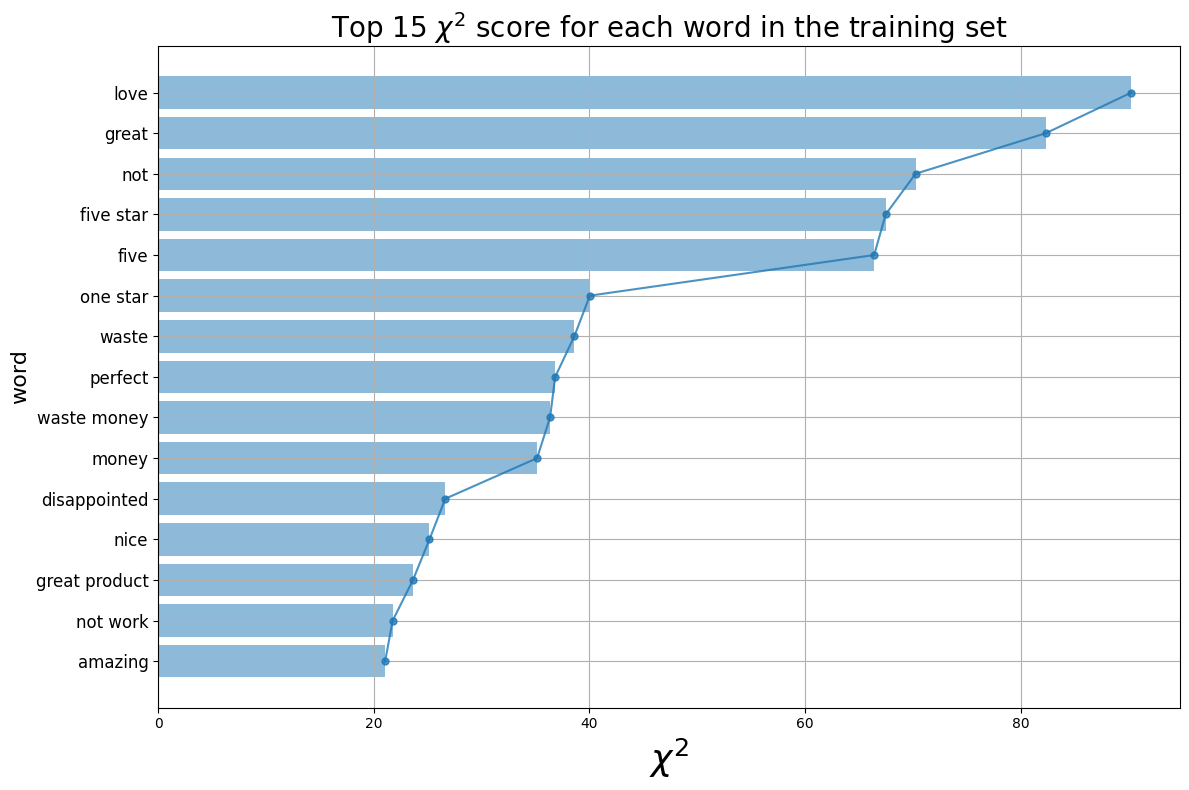

In [11]:
i = 15

chi2score = chi2(X_train_, y_train)[0]
scores = list(zip(cv.get_feature_names_out(), chi2score))
sorted_scores = sorted(scores, key=lambda x:x[1])
topchi2 = list(zip(*sorted_scores[-i:]))
x = range(len(topchi2[1]))
labels = topchi2[0]

plt.figure(figsize=(12, 8))
plt.barh(x,topchi2[1], align='center', alpha=0.5)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels, fontsize=12)
plt.xlabel('$\chi^2$', fontsize=26)
plt.ylabel('word', fontsize=16)
plt.title('Top {} $\chi^2$ score for each word in the training set'.format(i), fontsize=20)
plt.grid()
plt.tight_layout()
plt.show();

- Palabras como "waste", "waste money", "disappointed" probablemente indican reviews negativas
- Palabras como "love", "great", "perfect" probablemente indican reviews positivas

### 3.4 Modelo 1: `LogisticRegression` con búsqueda de mejor hiperparámetro

In [12]:
c_params = [0.01, 0.05, 0.25, 0.5, 1, 10, 100, 1000, 5000]

train_acc = list()
test_acc = list()
for c in c_params:
    lr = LogisticRegression(C=c, solver='lbfgs', max_iter=500)
    lr.fit(X_train_, y_train)

    train_predict = lr.predict(X_train_)
    test_predict = lr.predict(X_test_)

    print ("Accuracy for C={}: {}".format(c, accuracy_score(y_test, test_predict)))

    train_acc.append(accuracy_score(y_train, train_predict))
    test_acc.append(accuracy_score(y_test, test_predict))

Accuracy for C=0.01: 0.8645763842561708
Accuracy for C=0.05: 0.8719146097398266
Accuracy for C=0.25: 0.8879252835223482
Accuracy for C=0.5: 0.8872581721147431
Accuracy for C=1: 0.8905937291527685
Accuracy for C=10: 0.8839226150767178
Accuracy for C=100: 0.8692461641094062
Accuracy for C=1000: 0.8559039359573049
Accuracy for C=5000: 0.8579052701801201


In [13]:
print('Confussion matrix:\n{}'.format(confusion_matrix(y_test, test_predict)))
print('\nClassification report:\n{}'.format(classification_report(y_test, test_predict)))
print('Accuracy score:{}'.format(accuracy_score(y_test, test_predict)))

Confussion matrix:
[[650  98]
 [115 636]]

Classification report:
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       748
           1       0.87      0.85      0.86       751

    accuracy                           0.86      1499
   macro avg       0.86      0.86      0.86      1499
weighted avg       0.86      0.86      0.86      1499

Accuracy score:0.8579052701801201


#### Las métricas indican un buen modelo en general. Nno esta desbalanceado (F1-score sin sesgo hacia ninguna clase), pero esto ya lo habiamos "forzado" a que estuviera balanceado. Alto recall negativo, lo que indica que el modelo es sensible a detectar reviews negativas. 

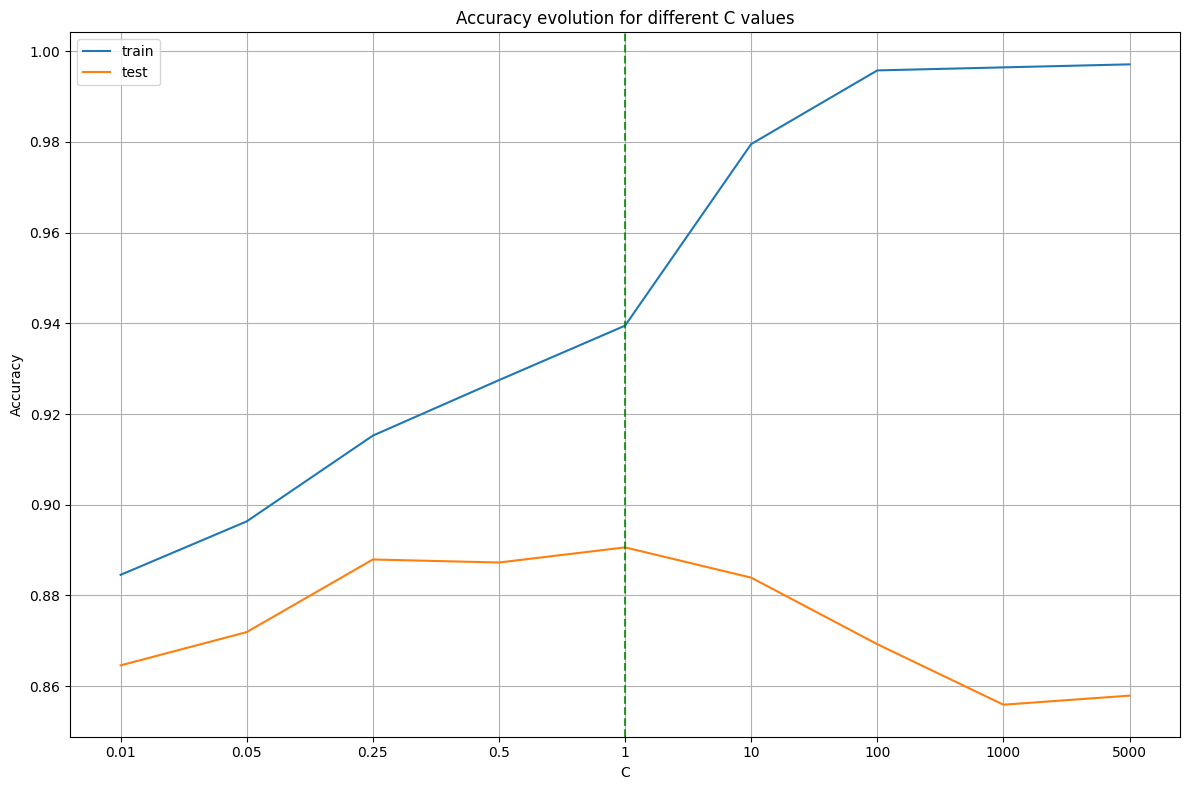

In [14]:
plt.figure(figsize=(12, 8))
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='test')
plt.axvline(np.argmax(test_acc), c='g', ls='--', alpha=0.8)
plt.title('Accuracy evolution for different C values')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.xticks(list(range(len(c_params))), c_params)
plt.tight_layout()
plt.show()

#### Elegimos el valor de C donde test (linea naranja) alcanza el máximo antes de que empiece a bajar (C=1. acc=0.89) 

In [15]:
# Re-entreno con el mejor C (C=1)
best_c = 1
lr_final = LogisticRegression(C=best_c, solver='lbfgs', max_iter=500)
lr_final.fit(X_train_, y_train)

# Evaluar el modelo final
y_pred_final = lr_final.predict(X_test_)
print(f"Modelo final con C={best_c}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_final):.4f}")
print(f"\nClassification Report:\n{classification_report(y_test, y_pred_final)}")

Modelo final con C=1
Accuracy: 0.8906

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89       748
           1       0.88      0.91      0.89       751

    accuracy                           0.89      1499
   macro avg       0.89      0.89      0.89      1499
weighted avg       0.89      0.89      0.89      1499



In [16]:
p, r, thresholds = precision_recall_curve(y_test, test_predict)

In [17]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')

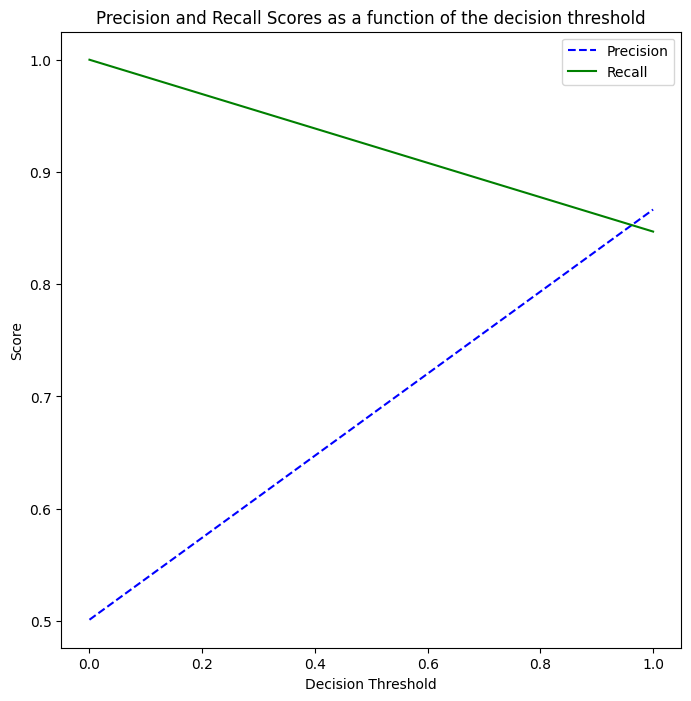

In [18]:
plot_precision_recall_vs_threshold(p, r, thresholds)

#### Algunos ejemplos de predicciones con este modelo:

In [19]:
def predict_review_sentiment(review_index, model):
    row = df.iloc[review_index]
    
    # Mostrar texto original si existe
    if 'reviewText' in df.columns:
        print(f'Review original: {row["reviewText"][:200]}...\n')
    
    # Obtener texto procesado 
    processed_text = row['review_processed_ML']
    if isinstance(processed_text, list):
        processed_text = ' '.join(str(word) for word in processed_text)
    else:
        processed_text = str(processed_text)
    
    print(f'Review procesada: {processed_text[:200]}...')
    
    # Sentimiento real
    actual = row['label_sentiment']
    sentiment_label = "Positivo" if actual == 1 else "Negativo"
    print(f'\nSentimiento real: {sentiment_label} ({actual})')
    
    # Predicción
    prediction = model.predict(cv.transform([processed_text]))[0]
    proba = model.predict_proba(cv.transform([processed_text]))[0]
    
    pred_label = "Positivo" if prediction == 1 else "Negativo"
    print(f'Predicción: {pred_label} ({prediction})')
    print(f'Probabilidades: Negativo={proba[0]:.1%}, Positivo={proba[1]:.1%}')
    
    match = "CORRECTO" if actual == prediction else "ERROR"
    print(f'\n{match}')


In [20]:
for i in random.sample(range(0, len(df)), 3):
    print('\nReview no. {}'.format(i))
    predict_review_sentiment(i, lr_final)


Review no. 4697
Review procesada: lost one hoping would great replacement wasnt travel case disappointing lost one hoping would great replacement wasnt...

Sentimiento real: Positivo (1)
Predicción: Positivo (1)
Probabilidades: Negativo=31.2%, Positivo=68.8%

CORRECTO

Review no. 4498
Review procesada: five star fantastic productso glad arrived brown glass bottle...

Sentimiento real: Negativo (0)
Predicción: Negativo (0)
Probabilidades: Negativo=86.4%, Positivo=13.6%

CORRECTO

Review no. 2475
Review procesada: wouldnt buy lace isnt frontal wigish like halloween wasnt expected...

Sentimiento real: Positivo (1)
Predicción: Positivo (1)
Probabilidades: Negativo=21.5%, Positivo=78.5%

CORRECTO


### 3.5 Modelo 2: `Naive Bayes (MultinomialNB)`

In [21]:
from sklearn.naive_bayes import MultinomialNB

In [22]:
# Entrenar Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train_, y_train)

,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


In [23]:
# Predicciones
y_pred_nb = nb_model.predict(X_test_)

In [24]:
# Evaluación
print("NAIVE BAYES - RESULTADOS")

print(f"Accuracy: {accuracy_score(y_test, y_pred_nb):.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_nb, target_names=['Positive', 'Negative']))
print(f"\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_nb))

NAIVE BAYES - RESULTADOS
Accuracy: 0.8786

Classification Report:
              precision    recall  f1-score   support

    Positive       0.90      0.85      0.88       748
    Negative       0.86      0.91      0.88       751

    accuracy                           0.88      1499
   macro avg       0.88      0.88      0.88      1499
weighted avg       0.88      0.88      0.88      1499


Confusion Matrix:
[[637 111]
 [ 71 680]]


### 3.6 Comparación de ambos modelos

In [26]:
# Calcular métricas para los modelos
from sklearn.metrics import precision_score, recall_score, f1_score

models_results = {
    'Logistic Regression': {
        'predictions': y_pred_final,
        'model': lr_final
    },
    'Naive Bayes': {
        'predictions': y_pred_nb,
        'model': nb_model
    },
}

# Crear tabla comparativa
comparison_data = []
for model_name, results in models_results.items():
    y_pred = results['predictions']
    comparison_data.append({
        'Modelo': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='weighted'),
        'Recall': recall_score(y_test, y_pred, average='weighted'),
        'F1-Score': f1_score(y_test, y_pred, average='weighted')
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.round(4)

print(comparison_df.to_string(index=False))

             Modelo  Accuracy  Precision  Recall  F1-Score
Logistic Regression    0.8906     0.8909  0.8906    0.8906
        Naive Bayes    0.8786     0.8797  0.8786    0.8785


#### **CONCLUSIONES:**

1. **Vectorización (TF-IDF)**:
   - TF-IDF capturó mejor las palabras informativas al ponderar por frecuencia inversa
   - Redujo el peso de palabras muy comunes que no aportan información
   - Generó features más discriminativas para el clasificador

2. **Comparación de Modelos**:
   - **Logistic Regression**: Buen equilibrio entre precisión y recall, interpretable
   - **Naive Bayes**: Rápido de entrenar, asume independencia entre features

3. **Observaciones**:
   - Los dos modelos tienen rendimiento similar, lo que sugiere que el preprocesado fue efectivo
   - La vectorización TF-IDF fue clave para el buen desempeño


### 3.7 Guardar modelo final elegido y vectorizador

In [27]:
# Seleccionar el modelo con mejor F1-Score
best_model_name = comparison_df.loc[comparison_df['F1-Score'].idxmax(), 'Modelo']
best_model = models_results[best_model_name]['model']

print(f"\nModelo elegido: {best_model_name}")
print(f"\nJustificación:")
print(f"- Mejor F1-Score: {comparison_df.loc[comparison_df['F1-Score'].idxmax(), 'F1-Score']:.4f}")

# Guardar modelo final
import pickle
import os

os.makedirs('outputs', exist_ok=True)
with open('Outputs/models/best_ml_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)
with open('Outputs/models/vectorizer.pkl', 'wb') as f:
    pickle.dump(cv, f)

print("\nModelo y vectorizador guardados en outputs/")


Modelo elegido: Logistic Regression

Justificación:
- Mejor F1-Score: 0.8906

Modelo y vectorizador guardados en outputs/
